## Caso Práctico GAN's
#### Objetivo: 
- Mejorar la diversidad de las imágenes de tumores cerebrales para un modelo de diagnóstico o onvestigación médica

### Descrompresión de archivos
Primero descomprimimos los archivos que utilizaremos para el dataset...

In [1]:
import zipfile
import os

def unzip_folder(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Paths to the zip files
temp_slice_zip = 'temp_slice.zip'
model_weight_zip = 'model_weight.zip'

# Paths to extract the contents
temp_slice_extract_to = 'temp_slice'
model_weight_extract_to = 'model_weight'

# Create directories if they don't exist
os.makedirs(temp_slice_extract_to, exist_ok=True)
os.makedirs(model_weight_extract_to, exist_ok=True)

# Unzip the folders
unzip_folder(temp_slice_zip, temp_slice_extract_to)
unzip_folder(model_weight_zip, model_weight_extract_to)

print("Descompresión completada.")

Descompresión completada.


### Preparación del entorno y carga de datos

#### Importaciones y Configuración Inicial

En esta celda, realizamos las siguientes acciones:

1. **Importaciones**:
    - `os`: Módulo para interactuar con el sistema operativo.
    - `torch` y `torch.nn`: Bibliotecas principales de PyTorch para construir y entrenar redes neuronales.
    - `torchvision.transforms`: Módulo para aplicar transformaciones a las imágenes.
    - `torch.utils.data`: Módulo para manejar datasets y dataloaders.
    - `torchvision.utils`: Utilidades de PyTorch para trabajar con imágenes.
    - `torch.autograd.Variable`: Clase para envolver tensores y habilitar el cálculo automático de gradientes.
    - `pathlib`: Módulo para trabajar con rutas de archivos.
    - `PIL.Image`: Módulo para trabajar con imágenes.
    - `IPython.display`: Módulo para mostrar imágenes en notebooks.
    - `random` y `math`: Módulos estándar de Python para operaciones aleatorias y matemáticas.

2. **Configuración de CUDA**:
    - `os.environ['CUDA_VISIBLE_DEVICES'] = "0"`: Configura la GPU que se utilizará (en este caso, la GPU 0).
    - `device = torch.device("cuda" if torch.cuda.is_available() else "cpu")`: Configura el dispositivo para PyTorch, utilizando GPU si está disponible, de lo contrario, CPU.

3. **Definición de Transformaciones para las Imágenes**:
    - `transforms.Compose`: Composición de varias transformaciones.
    - `transforms.Resize((64, 64))`: Redimensiona las imágenes a 64x64 píxeles.
    - `transforms.ToTensor()`: Convierte las imágenes a tensores de PyTorch.
    - `transforms.Normalize((0.5,), (0.5,))`: Normaliza las imágenes con una media de 0.5 y una desviación estándar de 0.5.

Estas configuraciones son esenciales para preparar el entorno y los datos antes de entrenar el modelo GAN.

In [2]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils
from torch.autograd import Variable
import pathlib
from PIL import Image
from IPython.display import display
import random
import math

# Configuración de CUDA
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definición de transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### Definición del Dataset

En esta celda, definimos una clase personalizada para manejar el dataset de imágenes de tumores cerebrales y configuramos un DataLoader para cargar las imágenes en lotes durante el entrenamiento.

1. **Definición de la Clase `BrainTumorDataset`**:
    - **`__init__`**: 
        - `root_dir`: Directorio raíz donde se encuentran las imágenes.
        - `transform`: Transformaciones a aplicar a las imágenes.
        - `self.image_paths`: Lista de rutas a las imágenes en el directorio raíz con extensión `.png`.
    - **`__len__`**: 
        - Devuelve el número total de imágenes en el dataset.
    - **`__getitem__`**: 
        - `idx`: Índice de la imagen a cargar.
        - `img_path`: Ruta de la imagen correspondiente al índice.
        - `image`: Carga la imagen y la convierte a formato RGB.
        - Aplica las transformaciones definidas si están disponibles.
        - Devuelve la imagen transformada.

2. **Carga del Dataset**:
    - `dataset = BrainTumorDataset(root_dir='ruta', transform=transform)`: Crea una instancia del dataset con el directorio raíz y las transformaciones definidas.
    - `dataloader = DataLoader(dataset, batch_size=128, shuffle=True)`: Configura un DataLoader para cargar las imágenes en lotes de tamaño 128 y barajar las imágenes en cada época.

El DataLoader es esencial para manejar eficientemente el dataset durante el entrenamiento del modelo, permitiendo cargar las imágenes en memoria en lotes y aplicar las transformaciones necesarias.

In [3]:
# Definición del dataset
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = list(pathlib.Path(root_dir).rglob('*.png'))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Carga del dataset
dataset = BrainTumorDataset(root_dir='temp_slice', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

### Definición del modelo GAN.

#### Definición del Generador

En esta celda, definimos la clase para el generador de la GAN. El generador toma un vector de ruido como entrada y produce una imagen generada.

##### Generador: `Generator`

El generador utiliza capas de convolución transpuesta para convertir un vector de ruido en una imagen.

- **`__init__`**:
    - Inicializa las capas del generador utilizando una secuencia de capas de convolución transpuesta, normalización por lotes y activaciones ReLU.
    - `self.main`: Define la arquitectura del generador como una secuencia de capas.
        - `nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False)`: Primera capa de convolución transpuesta que toma un vector de 100 dimensiones y lo convierte en un tensor de 512 canales.
        - `nn.BatchNorm2d(512)`: Normalización por lotes para estabilizar el entrenamiento.
        - `nn.ReLU(True)`: Función de activación ReLU.
        - Capas adicionales de convolución transpuesta, normalización por lotes y activaciones ReLU para aumentar la resolución de la imagen.
        - `nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)`: Última capa de convolución transpuesta que convierte el tensor en una imagen de 3 canales (RGB).
        - `nn.Tanh()`: Función de activación Tanh para escalar los valores de los píxeles entre -1 y 1.

- **`forward`**:
    - Define la pasada hacia adelante del generador.
    - `input`: Vector de ruido de entrada.
    - `return self.main(input)`: Pasa el vector de ruido a través de las capas del generador y devuelve la imagen generada.

El generador es una parte esencial de la GAN, ya que es responsable de crear imágenes realistas a partir de vectores de ruido.

In [4]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

#### Definición del Discriminador

En esta celda, definimos la clase para el discriminador de la GAN. El discriminador toma una imagen como entrada y produce una probabilidad de que la imagen sea real o falsa.

##### Discriminador: `Discriminator`

El discriminador utiliza capas de convolución para procesar la imagen de entrada y determinar su autenticidad.

- **`__init__`**:
    - Inicializa las capas del discriminador utilizando una secuencia de capas de convolución, normalización por lotes y activaciones Leaky ReLU.
    - `self.main`: Define la arquitectura del discriminador como una secuencia de capas.
        - `nn.Conv2d(3, 64, 4, 2, 1, bias=False)`: Primera capa de convolución que toma una imagen de 3 canales (RGB) y la convierte en un tensor de 64 canales.
        - `nn.LeakyReLU(0.2, inplace=True)`: Función de activación Leaky ReLU con un coeficiente de fuga de 0.2.
        - Capas adicionales de convolución, normalización por lotes y activaciones Leaky ReLU para procesar la imagen.
        - `nn.Conv2d(512, 1, 4, 1, 0, bias=False)`: Última capa de convolución que convierte el tensor en una probabilidad de un solo canal.
        - `nn.Sigmoid()`: Función de activación Sigmoid para escalar la probabilidad entre 0 y 1.

- **`forward`**:
    - Define la pasada hacia adelante del discriminador.
    - `input`: Imagen de entrada.
    - `return self.main(input)`: Pasa la imagen de entrada a través de las capas del discriminador y devuelve la probabilidad de que la imagen sea real o falsa.

El discriminador es una parte esencial de la GAN, ya que es responsable de evaluar la autenticidad de las imágenes generadas por el generador.

In [5]:
# Definición del Discriminador
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

### Entrenamiento del modelo

#### Inicialización de los Modelos, Optimizadores, Función de Pérdida y Etiquetas

En esta sección, inicializamos los componentes esenciales para entrenar la GAN, incluyendo los modelos, los optimizadores, la función de pérdida y las etiquetas.

1. **Inicialización de los Modelos**:
    - `netG = Generator().to(device)`: 
        - Inicializa el generador (`Generator`) y lo mueve al dispositivo especificado (`device`), que puede ser una GPU o CPU.
    - `netD = Discriminator().to(device)`:
        - Inicializa el discriminador (`Discriminator`) y lo mueve al dispositivo especificado (`device`).

2. **Inicialización de los Optimizadores**:
    - `optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))`:
        - Inicializa el optimizador Adam para el discriminador (`netD`).
        - `lr=0.0002`: Tasa de aprendizaje.
        - `betas=(0.5, 0.999)`: Parámetros beta para el optimizador Adam.
    - `optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))`:
        - Inicializa el optimizador Adam para el generador (`netG`).
        - `lr=0.0002`: Tasa de aprendizaje.
        - `betas=(0.5, 0.999)`: Parámetros beta para el optimizador Adam.

3. **Definición de la Función de Pérdida**:
    - `criterion = nn.BCELoss()`:
        - Define la función de pérdida de entropía cruzada binaria (Binary Cross Entropy Loss).
        - Esta función de pérdida se utiliza para medir la diferencia entre las etiquetas reales y las predicciones del modelo.

4. **Etiquetas Reales y Falsas**:
    - `real_label = 1`:
        - Define la etiqueta para las imágenes reales como 1.
    - `fake_label = 0`:
        - Define la etiqueta para las imágenes falsas como 0.

Estos componentes son esenciales para configurar el proceso de entrenamiento de la GAN, permitiendo que los modelos se actualicen y aprendan a generar imágenes realistas.

In [ ]:
# Inicialización de los modelos
netG = Generator().to(device)
netD = Discriminator().to(device)

# Inicialización de los optimizadores
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Definición de la función de pérdida
criterion = nn.BCELoss()

# Etiquetas reales y falsas
real_label = 1
fake_label = 0

#### Definición de la Clase `GANTrainer`

En esta celda, definimos la clase `GANTrainer`, que encapsula el proceso de entrenamiento de la GAN y permite utilizar `GridSearchCV` de `scikit-learn` para buscar el número óptimo de épocas.

##### Clase `GANTrainer`

La clase `GANTrainer` hereda de `BaseEstimator` y `RegressorMixin` de `scikit-learn`, lo que permite integrarla con `GridSearchCV`.

- **`__init__`**:
    - Inicializa los parámetros y componentes necesarios para entrenar la GAN.
    - `num_epochs`: Número de épocas para entrenar.
    - `device`: Dispositivo (GPU o CPU) para ejecutar los cálculos.
    - `netG`: Instancia del generador (`Generator`).
    - `netD`: Instancia del discriminador (`Discriminator`).
    - `criterion`: Función de pérdida de entropía cruzada binaria (`BCELoss`).
    - `optimizerD`: Optimizador Adam para el discriminador.
    - `optimizerG`: Optimizador Adam para el generador.

- **`fit`**:
    - Entrena la GAN utilizando los datos proporcionados.
    - `X`: Datos de entrada (imágenes).
    - `dataloader`: Carga los datos en lotes y los baraja.
    - `real_label` y `fake_label`: Etiquetas para las imágenes reales y falsas.
    - Bucle de entrenamiento:
        - Actualiza el discriminador con datos reales y falsos.
        - Actualiza el generador.
        - Calcula las pérdidas y realiza los pasos de optimización.

- **`score`**:
    - Calcula una métrica de rendimiento para evaluar el modelo.
    - `X`: Datos de entrada (imágenes).
    - `total_lossD`: Suma de las pérdidas del discriminador para todas las imágenes reales.
    - Devuelve la pérdida total del discriminador (negativa porque `GridSearchCV` maximiza la métrica).

Esta clase permite encapsular el proceso de entrenamiento de la GAN y utilizar `GridSearchCV` para buscar el número óptimo de épocas.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from torch.utils.data import DataLoader

class GANTrainer(BaseEstimator, RegressorMixin):
    def __init__(self, num_epochs=10):
        self.num_epochs = num_epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.netG = Generator().to(self.device)
        self.netD = Discriminator().to(self.device)
        self.criterion = nn.BCELoss()
        self.optimizerD = optim.Adam(self.netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.optimizerG = optim.Adam(self.netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

    def fit(self, X, y=None):
        dataloader = DataLoader(X, batch_size=128, shuffle=True)
        real_label = 1
        fake_label = 0

        for epoch in range(self.num_epochs):
            for i, data in enumerate(dataloader, 0):
                # Actualización del discriminador con datos reales
                self.netD.zero_grad()
                real_images = data.to(self.device)
                batch_size = real_images.size(0)
                labels = torch.full((batch_size, 1), real_label, dtype=torch.float, device=self.device)
                output = self.netD(real_images).view(batch_size, -1)
                lossD_real = self.criterion(output, labels)
                lossD_real.backward()
                D_x = output.mean().item()

                # Actualización del discriminador con datos falsos
                noise = torch.randn(batch_size, 100, 1, 1, device=self.device)
                fake_images = self.netG(noise)
                labels.fill_(fake_label)
                output = self.netD(fake_images.detach()).view(batch_size, -1)
                lossD_fake = self.criterion(output, labels)
                lossD_fake.backward()
                D_G_z1 = output.mean().item()
                lossD = lossD_real + lossD_fake
                self.optimizerD.step()

                # Actualización del generador
                self.netG.zero_grad()
                labels.fill_(real_label)
                output = self.netD(fake_images).view(batch_size, -1)
                lossG = self.criterion(output, labels)
                lossG.backward()
                D_G_z2 = output.mean().item()
                self.optimizerG.step()

        return self

    def score(self, X, y=None):
        # Aquí puedes definir una métrica de rendimiento, por ejemplo, la pérdida del discriminador
        dataloader = DataLoader(X, batch_size=128, shuffle=True)
        total_lossD = 0
        with torch.no_grad():
            for data in dataloader:
                real_images = data.to(self.device)
                batch_size = real_images.size(0)
                labels = torch.full((batch_size, 1), 1, dtype=torch.float, device=self.device)
                output = self.netD(real_images).view(batch_size, -1)
                lossD_real = self.criterion(output, labels)
                total_lossD += lossD_real.item()
        return -total_lossD  # Negativo porque GridSearchCV maximiza la métrica
print(f'Mejor numero de epocas: {self.num_epochs}') #volver a correrrrrrrrr

#### Bucle de Entrenamiento del Modelo

En esta celda, definimos el bucle de entrenamiento para la GAN, que incluye la actualización del discriminador y el generador en cada iteración.

1. **Número de Épocas**:
    - `num_epochs = 2500`: Define el número de épocas para entrenar el modelo.

2. **Bucle de Entrenamiento**:
    - `for epoch in range(num_epochs)`: Itera sobre el número de épocas.
    - `for i, data in enumerate(dataloader, 0)`: Itera sobre los lotes de datos en el `dataloader`.

3. **Actualización del Discriminador con Datos Reales**:
    - `netD.zero_grad()`: Reinicia los gradientes del discriminador.
    - `real_images = data.to(device)`: Mueve las imágenes reales al dispositivo (GPU o CPU).
    - `batch_size = real_images.size(0)`: Obtiene el tamaño del lote.
    - `labels = torch.full((batch_size, 1), real_label, dtype=torch.float, device=device)`: Crea etiquetas reales.
    - `output = netD(real_images).view(batch_size, -1)`: Pasa las imágenes reales a través del discriminador.
    - `lossD_real = criterion(output, labels)`: Calcula la pérdida del discriminador con datos reales.
    - `lossD_real.backward()`: Calcula los gradientes para la pérdida.
    - `D_x = output.mean().item()`: Calcula la media de las salidas del discriminador para las imágenes reales.

4. **Actualización del Discriminador con Datos Falsos**:
    - `noise = torch.randn(batch_size, 100, 1, 1, device=device)`: Genera un vector de ruido.
    - `fake_images = netG(noise)`: Genera imágenes falsas a partir del vector de ruido.
    - `labels.fill_(fake_label)`: Crea etiquetas falsas.
    - `output = netD(fake_images.detach()).view(batch_size, -1)`: Pasa las imágenes falsas a través del discriminador.
    - `lossD_fake = criterion(output, labels)`: Calcula la pérdida del discriminador con datos falsos.
    - `lossD_fake.backward()`: Calcula los gradientes para la pérdida.
    - `D_G_z1 = output.mean().item()`: Calcula la media de las salidas del discriminador para las imágenes falsas.
    - `lossD = lossD_real + lossD_fake`: Suma las pérdidas reales y falsas.
    - `optimizerD.step()`: Actualiza los pesos del discriminador.

5. **Actualización del Generador**:
    - `netG.zero_grad()`: Reinicia los gradientes del generador.
    - `labels.fill_(real_label)`: Crea etiquetas reales para las imágenes generadas.
    - `output = netD(fake_images).view(batch_size, -1)`: Pasa las imágenes falsas a través del discriminador.
    - `lossG = criterion(output, labels)`: Calcula la pérdida del generador.
    - `lossG.backward()`: Calcula los gradientes para la pérdida.
    - `D_G_z2 = output.mean().item()`: Calcula la media de las salidas del discriminador para las imágenes generadas.
    - `optimizerG.step()`: Actualiza los pesos del generador.

6. **Imprimir Estadísticas de Entrenamiento**:
    - `if i % 50 == 0`: Imprime las estadísticas cada 50 iteraciones.
    - `print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {lossD.item():.4f} Loss_G: {lossG.item():.4f} D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')`: Imprime las pérdidas del discriminador y el generador, y las medias de las salidas del discriminador.

Este bucle de entrenamiento es esencial para actualizar los pesos del generador y el discriminador, permitiendo que la GAN aprenda a generar imágenes realistas.

In [9]:
# Bucle de entrenamiento
num_epochs = 2500
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Actualización del discriminador con datos reales
        netD.zero_grad()
        real_images = data.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, dtype=torch.float, device=device)
        output = netD(real_images).view(batch_size, -1)
        #print(f'Output size (real): {output.size()}, Labels size: {labels.size()}')
        lossD_real = criterion(output, labels)
        lossD_real.backward()
        D_x = output.mean().item()

        # Actualización del discriminador con datos falsos
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_images = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake_images.detach()).view(batch_size, -1)
        #print(f'Output size (fake): {output.size()}, Labels size: {labels.size()}')
        lossD_fake = criterion(output, labels)
        lossD_fake.backward()
        D_G_z1 = output.mean().item()
        lossD = lossD_real + lossD_fake
        optimizerD.step()

        # Actualización del generador
        netG.zero_grad()
        labels.fill_(real_label)
        output = netD(fake_images).view(batch_size, -1)
        #print(f'Output size (generator): {output.size()}, Labels size: {labels.size()}')
        lossG = criterion(output, labels)
        lossG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Imprimir estadísticas de entrenamiento
        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] '
                  f'Loss_D: {lossD.item():.4f} Loss_G: {lossG.item():.4f} '
                  f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

[0/2500][0/2] Loss_D: 1.1675 Loss_G: 1.9543 D(x): 0.5636 D(G(z)): 0.4402 / 0.1475
[1/2500][0/2] Loss_D: 0.2998 Loss_G: 3.8905 D(x): 0.9997 D(G(z)): 0.2551 / 0.0222
[2/2500][0/2] Loss_D: 0.0517 Loss_G: 4.4721 D(x): 0.9995 D(G(z)): 0.0497 / 0.0126
[3/2500][0/2] Loss_D: 0.0587 Loss_G: 4.6000 D(x): 0.9989 D(G(z)): 0.0555 / 0.0111
[4/2500][0/2] Loss_D: 0.0432 Loss_G: 5.0053 D(x): 0.9972 D(G(z)): 0.0394 / 0.0074
[5/2500][0/2] Loss_D: 0.0281 Loss_G: 5.2548 D(x): 0.9946 D(G(z)): 0.0223 / 0.0058
[6/2500][0/2] Loss_D: 0.0403 Loss_G: 5.2993 D(x): 0.9948 D(G(z)): 0.0343 / 0.0057
[7/2500][0/2] Loss_D: 0.0270 Loss_G: 5.6588 D(x): 0.9968 D(G(z)): 0.0234 / 0.0040
[8/2500][0/2] Loss_D: 0.0196 Loss_G: 5.7895 D(x): 0.9975 D(G(z)): 0.0169 / 0.0035
[9/2500][0/2] Loss_D: 0.0217 Loss_G: 5.9240 D(x): 0.9979 D(G(z)): 0.0194 / 0.0031
[10/2500][0/2] Loss_D: 0.0191 Loss_G: 6.0329 D(x): 0.9980 D(G(z)): 0.0169 / 0.0027
[11/2500][0/2] Loss_D: 0.0194 Loss_G: 6.1297 D(x): 0.9978 D(G(z)): 0.0171 / 0.0025
[12/2500][0/2]

### Evaluación y generación de imágenes
En esta celda, generamos imágenes falsas utilizando el generador entrenado y las guardamos en un archivo de imagen. Luego, mostramos las imágenes generadas.

1. **Generar Imágenes Falsas**:
    - `with torch.no_grad()`: Desactiva el cálculo de gradientes para ahorrar memoria y acelerar el proceso.
    - `noise = torch.randn(64, 100, 1, 1, device=device)`:
        - Genera un tensor de ruido aleatorio con dimensiones (64, 100, 1, 1).
        - `64`: Número de imágenes a generar.
        - `100`: Dimensiones del vector de ruido.
        - `1, 1`: Dimensiones espaciales del tensor de ruido.
        - `device=device`: Mueve el tensor de ruido al dispositivo (GPU o CPU).
    - `fake_images = netG(noise).detach().cpu()`:
        - Pasa el tensor de ruido a través del generador (`netG`) para generar imágenes falsas.
        - `detach()`: Desconecta el tensor del gráfico de cálculo de gradientes.
        - `cpu()`: Mueve las imágenes generadas a la CPU.
    - `vutils.save_image(fake_images, 'fake_images.png', normalize=True)`:
        - Guarda las imágenes generadas en un archivo llamado `fake_images.png`.
        - `normalize=True`: Normaliza las imágenes para que los valores de los píxeles estén en el rango [0, 1].

2. **Mostrar las Imágenes Generadas**:
    - `display(Image.open('fake_images.png'))`:
        - Abre el archivo de imagen `fake_images.png`.
        - Muestra las imágenes generadas en el notebook.

Este proceso permite visualizar las imágenes generadas por el generador entrenado, lo que es útil para evaluar la calidad de las imágenes y el rendimiento del modelo.

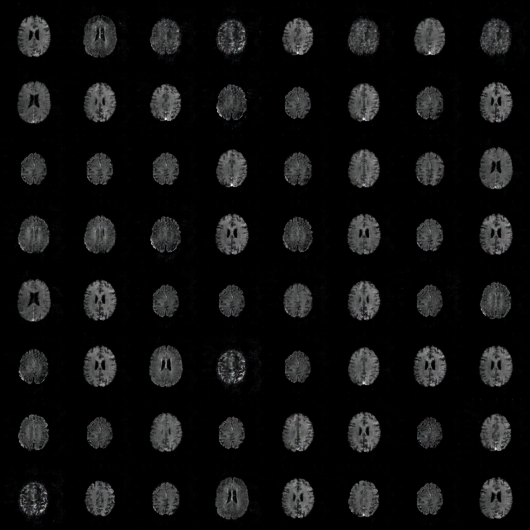

In [10]:
# Generar imágenes falsas
with torch.no_grad():
    noise = torch.randn(64, 100, 1, 1, device=device)
    fake_images = netG(noise).detach().cpu()
    vutils.save_image(fake_images, 'fake_images.png', normalize=True)

# Mostrar las imágenes generadas
display(Image.open('fake_images.png'))

### Conclusión

En este caso práctico, hemos desarrollado y entrenado una Generative Adversarial Network (GAN) para generar imágenes de tumores cerebrales. A lo largo del proceso, hemos:

1. **Preparado el entorno y los datos**: Configuramos el entorno de CUDA y definimos las transformaciones necesarias para las imágenes.
2. **Definido el modelo GAN**: Implementamos las clases para el generador y el discriminador.
3. **Entrenado el modelo**: Configuramos los optimizadores, la función de pérdida y entrenamos la GAN utilizando un bucle de entrenamiento.
4. **Generado imágenes falsas**: Utilizamos el generador entrenado para crear y visualizar imágenes de tumores cerebrales.

Este caso práctico, demuestra cómo las GANs pueden ser aplicadas en el campo de la biomédica para generar imágenes sintéticas. Aunque no ibtuvimos el mejor resultado, sabemos el potencial que tienen las GANs para ser útiles para la investigación y el desarrollo de nuevas técnicas de diagnóstico y tratamiento.